In [39]:
# Setup for notebook

# Setup for pd, sns and plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setup for BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

In [40]:
# Setup for BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

# Specify the filename of your service account key (make sure it's in the same folder as your notebook)
key_path = '/home/hanafi/ntu-sctp-dsai1f-project-team6/Citibike_Analysis/forward-garden-461903-m9-863379912db1.json'

# Confirm the file exists (optional check)
import os
print("Key exists:", os.path.exists(key_path))  # Should return True

# Create credentials and BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project='forward-garden-461903-m9')



Key exists: True


In [44]:
query = """
SELECT
  trip_id,
  bike_type_id,
  distance_m,
  duration_mins,
  membership_type_id,
  price_paid
FROM `forward-garden-461903-m9.citibike.fact_trips`
ORDER BY RAND()
LIMIT 10000
"""


In [45]:
client = bigquery.Client(credentials=credentials, project='forward-garden-461903-m9')


In [46]:
df = client.query(query).to_dataframe()
print(df.head())


/home/hanafi/miniconda3/envs/dsai_project/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


            trip_id                      bike_type_id   distance_m  \
0  9B8AA22D04E5606D  f877892b7f02356b109fce82d4dfc5ca  1019.997568   
1  41A16D61FDC2B21C  f37b539769f48b546ee51fc0be867626  1143.559752   
2  9EE5B5CAD62C3E77  f877892b7f02356b109fce82d4dfc5ca  1249.120602   
3  2D57723FB7190DCF  f877892b7f02356b109fce82d4dfc5ca   807.460403   
4  BDC39C0270C8CFD1  f877892b7f02356b109fce82d4dfc5ca  1304.029527   

   duration_mins                membership_type_id  price_paid  
0              6  aa08769cdcb26674c6706093503ff0a3        1.50  
1              8  aa08769cdcb26674c6706093503ff0a3        0.00  
2              8  c81bef2d87e668462190bb2281874bb5        3.04  
3              3  c81bef2d87e668462190bb2281874bb5        1.14  
4             23  c81bef2d87e668462190bb2281874bb5        8.74  


In [47]:
# Map IDs to Readable names
# f37b539769f48b546ee51fc0be867626 is classic_bike
# f877892b7f02356b109fce82d4dfc5ca is electric_bike

# Define the mapping
bike_type_mapping = {
    'f37b539769f48b546ee51fc0be867626': 'classic_bike',
    'f877892b7f02356b109fce82d4dfc5ca': 'electric_bike'
}

# Apply it to create new column
df['bike_type_name'] = df['bike_type_id'].map(bike_type_mapping)

In [50]:
df.info()
df.describe()

# Failure flag logic
df['suspected_failure'] = (
    (df['duration_mins'] < 1) |
    (df['duration_mins'] > 180) |
    (df['distance_m'] == 0) |
    (df['distance_m'] > 10000)
).astype(int)

# Failure rate by bike type
df.groupby('bike_type_name')['suspected_failure'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trip_id             10000 non-null  object 
 1   bike_type_id        10000 non-null  object 
 2   distance_m          10000 non-null  float64
 3   duration_mins       10000 non-null  Int64  
 4   membership_type_id  10000 non-null  object 
 5   price_paid          10000 non-null  float64
 6   bike_type_name      10000 non-null  object 
dtypes: Int64(1), float64(2), object(4)
memory usage: 556.8+ KB


bike_type_name
classic_bike     0.057272
electric_bike    0.030740
Name: suspected_failure, dtype: float64

/tmp/ipykernel_2693335/3663244474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


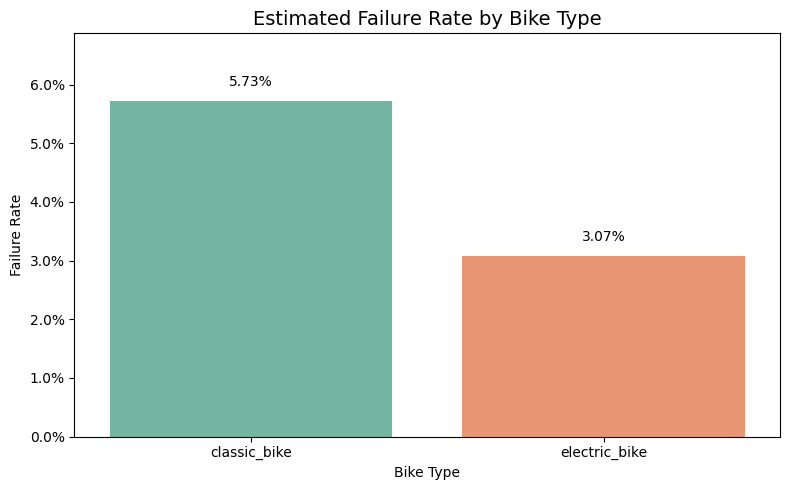

In [51]:
failure_by_bike = df.groupby('bike_type_name')['suspected_failure'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=failure_by_bike,
    x='bike_type_name',
    y='suspected_failure',
    palette='Set2'
)

plt.title('Estimated Failure Rate by Bike Type', fontsize=14)
plt.ylabel('Failure Rate')
plt.xlabel('Bike Type')
plt.ylim(0, failure_by_bike['suspected_failure'].max() * 1.2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Show exact values on top of bars
for index, row in failure_by_bike.iterrows():
    plt.text(index, row['suspected_failure'] + 0.002, f"{row['suspected_failure']:.2%}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Key Findings:

```Python

The chart compares the failure rates of two bike types:

Classic Bikes → ~5.73%

Electric Bikes → ~3.07%`


1. Classic Bikes Fail More Often

- The failure rate of classic bikes is nearly double that of electric bikes.

- Possible reasons:

   They are older or more widely used.

   Heavier mechanical wear (chains, pedals, brakes).

   Less regular maintenance or servicing.

2. Electric Bikes Might Be Newer or Better Maintained

- Despite being more complex, electric bikes have a lower failure rate, possibly due to:

    Proactive monitoring systems.

    Being newer additions to the fleet.

    Stricter maintenance schedules.

3. Impact on Operations

- High failure rates in classic bikes could lead to:

    More downtime.

    User dissatisfaction.

    Greater repair and replacement costs.

4. Strategic Decisions

- Findings could justify:

    Retiring older classic bikes.

    Expanding electric bike deployment.

    Reevaluating maintenance strategies.

```